In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [2]:
class Pair_trading():
    def __init__(self, data_var,data_preco, par, valor_inicial):
        self.financeiro = valor_inicial
        self.posicionado = 0 #comeca sem nenhuma operação aberta
        self.lista_resultado_operacoes = []
        self.lista_evolucao_carteira = []
        self.lista_dias_carregando = []
        self.lista_rentabilidade_operacao = []
        self.contador_dias = 0 
        self.perm_pct_acumulado = 1
        #guarda tickers das acoes
        self.t1 = par[0] 
        self.t2 = par[1]
        self.volume_operacao = 0

        self.dados_var = data_var
        self.dados_preco = data_preco

    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs
        
    def condicoes_operar(self,zs, gatilho_high, preco_s1, preco_s2, index):
        if zs >= gatilho_high and self.posicionado == 0:
            #parametros para iniciar operacao
            self.posicionado = 1 #entrou em uma operacao            
            self.volume = (self.financeiro/2)//preco_s1
            self.razao = preco_s1/preco_s2
            self.contador_dias = index
            #guarda dados de quantas ações está comprado/vendido
            self.qtd_s1 =  self.volume
            self.qtd_s2 =  self.volume*self.razao
            #calcula valor total da compra e venda (idealmente devem ser iguais)
            valor_operado_s1 =  preco_s1*self.qtd_s1 #vende  s1 (credita caixa)
            valor_operado_s2 = -preco_s2*self.qtd_s2 #compra s2 (debita caixa) 
#             print(f'v1  R${valor_operado_s1:.2f} | v2 R${valor_operado_s2:.2f}')
#             print(f'C1  R${preco_s1:.2f} | D2 R${(preco_s2*self.razao):.2f}')
            self.financeiro += valor_operado_s1 + valor_operado_s2

        elif zs <= 0.08 and self.posicionado == 1:
            #calcula preço das açoes que estão em carteira
            valor_operado_s1 = -self.qtd_s1*preco_s1 #compra s1 (debita  caixa) 
            valor_operado_s2 =  self.qtd_s2*preco_s2 #vende  s2 (credita caixa)
#             print(f'v1 R${valor_operado_s1:.2f} | v2  R${valor_operado_s2:.2f}')
#             print(f'D1  R${preco_s1:.2f} | C2 R${(preco_s2*self.razao):.2f}')
            resultado_trade = valor_operado_s1 + valor_operado_s2 
#             print(f'resu: R${resultado_trade:.2f}\n')
            self.financeiro += resultado_trade 
            #zera quantidades de ações sendo operadas
            self.qtd_s1 -= self.qtd_s1
            self.qtd_s2 -= self.qtd_s2
            #guarda dados para acompanhamento ao longo do tempo
            pct_change_trade = resultado_trade/(self.financeiro-resultado_trade)
            self.perm_pct_acumulado = self.perm_pct_acumulado*(1+pct_change_trade)
            self.lista_rentabilidade_operacao.append(pct_change_trade*100)
            self.lista_evolucao_carteira.append(self.financeiro)
            self.lista_dias_carregando.append(index-self.contador_dias)
            self.lista_resultado_operacoes.append(resultado_trade)
            #zera parametros para próximas operações 
            self.posicionado = 0
            self.razao = 0
            self.volume = 0
            self.contador_dias = 0
        
    def opera(self):
        period = 45
        c = 0
        s1 = self.dados_var[self.t1]
        s2 = self.dados_var[self.t2]
        for index in range(period, len(self.dados_var)):
            j1 = (s1[c:index]) #seleciona a acao 1 com uma janela com *period* dias 
            j2 = (s2[c:index])

            preco_s1 = self.dados_preco[self.t1][self.dados_var.index == index].values[0]
            preco_s2 = self.dados_preco[self.t2][self.dados_var.index == index].values[0]
            
            zs = self.calcula_zscore_spread(stock1=j1,stock2=j2)
            self.condicoes_operar(zs=zs, gatilho_high = 1.1, preco_s1=preco_s1, preco_s2=preco_s2, index=index)
            c += 1

        

In [3]:
#data = pd.read_excel('/home/daniel/Desktop/Projetos/mql_python/Relatório 1/dados_relatorio.xlsx')[1:] #linux
data = pd.read_excel('C:/Users/danie/Desktop/mql_python/todos_diretorios_desenvolvimento_projeto/Relatório 1/dados_relatorio.xlsx')[1:] #windows
data_var = data.drop('time',axis=1).pct_change()[1:1481]
data_preco = data[1:1481]

In [14]:
print(data.columns.tolist())

['time', 'close IBOV', 'close ABEV3', 'close AZUL4', 'close B3SA3', 'close BBAS3', 'close BBDC3', 'close BBDC4', 'close BBSE3', 'close BEEF3', 'close BPAC11', 'close BRAP4', 'close BRDT3', 'close BRFS3', 'close BRKM5', 'close BRML3', 'close BTOW3', 'close CCRO3', 'close CIEL3', 'close CMIG4', 'close COGN3', 'close CPFE3', 'close CRFB3', 'close CSAN3', 'close CSNA3', 'close CVCB3', 'close CYRE3', 'close ECOR3', 'close EGIE3', 'close ELET3', 'close ELET6', 'close EMBR3', 'close ENBR3', 'close ENGI11', 'close EQTL3', 'close FLRY3', 'close GGBR4', 'close GNDI3', 'close GOAU4', 'close GOLL4', 'close HAPV3', 'close HGTX3', 'close HYPE3', 'close IGTA3', 'close IRBR3', 'close ITSA4', 'close ITUB4', 'close JBSS3', 'close KLBN11', 'close LAME4', 'close LREN3', 'close MGLU3', 'close MRFG3', 'close MRVE3', 'close MULT3', 'close NTCO3', 'close PETR3', 'close PETR4', 'close QUAL3', 'close RADL3', 'close RAIL3', 'close RENT3', 'close SANB11', 'close SBSP3', 'close SULA11', 'close SUZB3', 'close TAEE1

In [5]:
tickers = [['close BBDC3','close BTOW3'],['close ECOR3','close GOLL4'],['close CSNA3','close MRFG3'],['close QUAL3','close USIM5']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']

In [16]:
lista_pares_usados = []
dic = {}
for i in tickers:
    a = (i[0]+' x '+i[1])
    lista_pares_usados.append(a)
    dic[a] = Pair_trading(data_var=data_var, data_preco=data_preco, par=i, valor_inicial=1000)
    dic[a].opera()


In [17]:
for k,v in dic.items():
    print(k)

close BBDC3 x close BTOW3
close ECOR3 x close GOLL4
close CSNA3 x close MRFG3
close QUAL3 x close USIM5


Valor final em carteira: R$63417.99
peformance acumulado 6341.80% em 87 operações


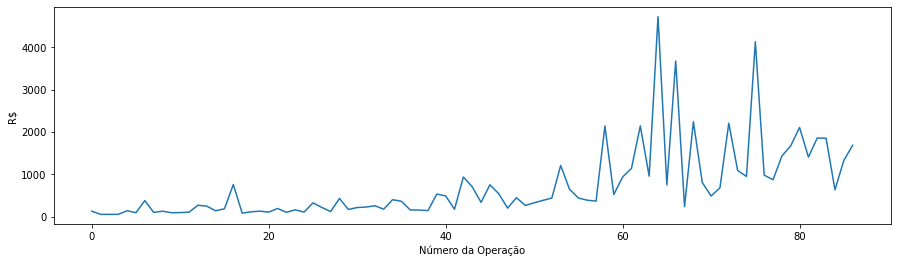

In [18]:
plt.figure(figsize=[15,4])
l1 = dic[lista_pares_usados[1]].lista_resultado_operacoes
l2 = dic[lista_pares_usados[1]].financeiro
l3 = dic[lista_pares_usados[1]].perm_pct_acumulado
print(f'Valor final em carteira: R${l2:.2f}')
print(f'peformance acumulado {l3*100:.2f}% em {len(l1)} operações')
plt.plot(l1)
plt.ylabel('R$')
plt.xlabel('Número da Operação')
plt.show()

In [19]:
print('Informações sobre o ganho em R$ das operações')
l1_series = pd.DataFrame(l1)
print(l1_series.describe())

Informações sobre o ganho em R$ das operações
                 0
count    87.000000
mean    717.448188
std     884.933243
min      50.186940
25%     156.809533
50%     382.045205
75%     934.090108
max    4721.164207


In [20]:
for k,v in dic.items():
    lista_dias_series = pd.Series(v.lista_rentabilidade_operacao)
    print(k,lista_dias_series.describe(),'\n |||||||||||||||||||||||||||||||||||||||||||')  

close BBDC3 x close BTOW3 count    90.000000
mean      4.175456
std       2.956626
min       0.706510
25%       2.402288
50%       3.544289
75%       4.731771
max      19.726894
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
close ECOR3 x close GOLL4 count    87.000000
mean      4.966653
std       4.292971
min       0.672368
25%       2.396549
50%       3.488876
75%       5.816763
max      24.986115
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
close CSNA3 x close MRFG3 count    99.000000
mean      2.780047
std       3.104148
min      -1.635955
25%       1.251669
50%       2.062583
75%       3.577732
max      20.361204
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
close QUAL3 x close USIM5 count    87.000000
mean      4.360294
std       4.238765
min      -2.980357
25%       2.022365
50%       3.426304
75%       5.316152
max      24.834531
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||


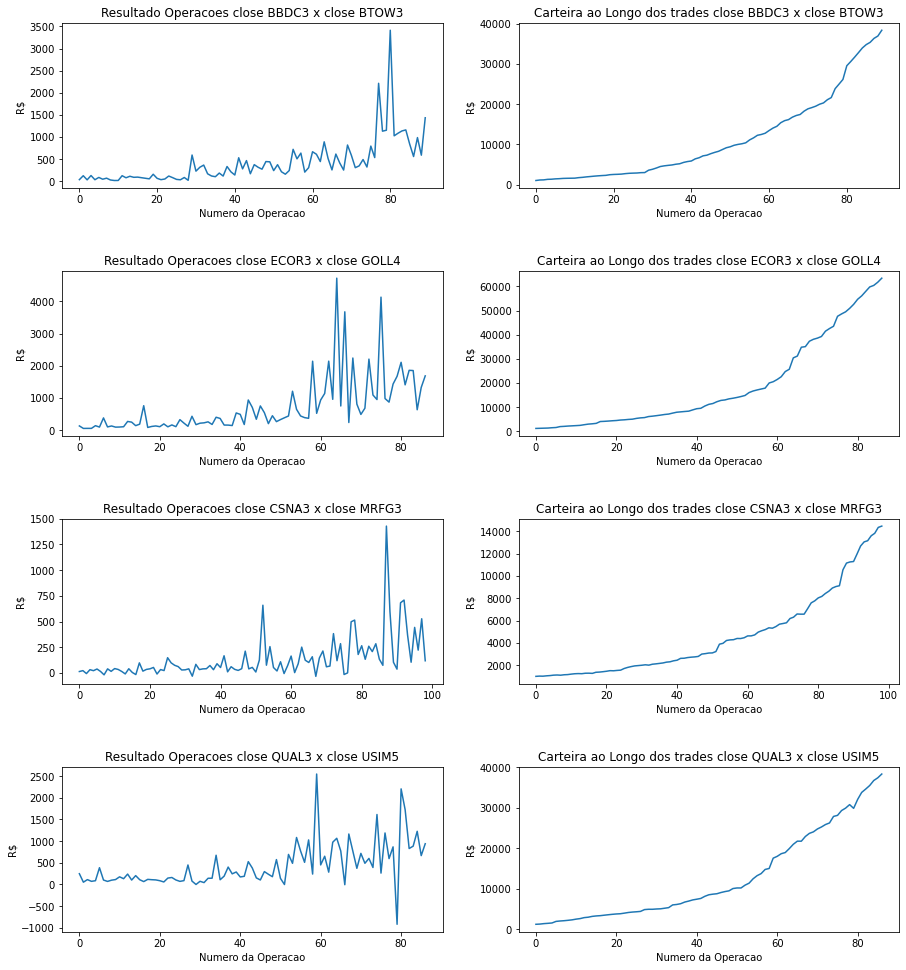

In [21]:
fig = plt.figure(figsize=(15, 30))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)

contador1 = 1
for i in lista_pares_usados:
    plt.subplot(8, 2, contador1)
    plt.plot(dic[i].lista_resultado_operacoes)
    plt.title('Resultado Operacoes '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    
    contador1 += 1
    plt.subplot(8, 2, contador1)
    plt.plot(dic[i].lista_evolucao_carteira)
    plt.title('Carteira ao Longo dos trades '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')

    contador1 += 1
    
plt.show()

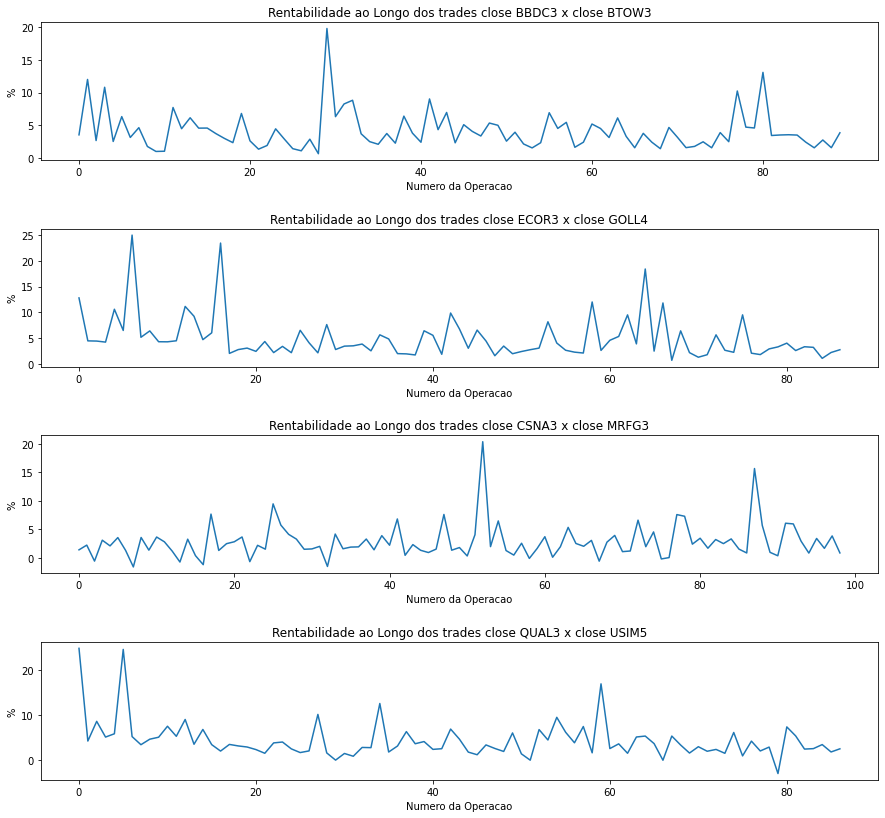

In [22]:
fig = plt.figure(figsize=(15, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)

contador1 = 1
for i in lista_pares_usados:
    
#     plt.subplot(8, 2, contador1)
#     plt.hist(dic[i].lista_dias_carregando, bins=8)
#     plt.title('Dias Posicionado '+ i)
#     plt.xlabel('Numero da Operacao')
#     plt.ylabel('R$')
#     contador1+=1

    plt.subplot(8, 1, contador1)
    plt.plot(dic[i].lista_rentabilidade_operacao)
    plt.title('Rentabilidade ao Longo dos trades '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('%')

    contador1 += 1

plt.show()

In [24]:
data = pd.read_excel('C:/Users/danie/Desktop/mql_python/diretorio_entrega_final/dados_relatorio_final.xlsx')
data_var = data.drop('time',axis=1).pct_change()[1:]
data_preco = data[1:]

In [29]:
data.columns

Index(['time', 'IBOV', 'ABEV3', 'BBAS3', 'BBDC3', 'BBDC4', 'BBSE3', 'BRAP4',
       'BRFS3', 'BRKM5', 'BRML3', 'B3SA3', 'CCRO3', 'CIEL3', 'CMIG4', 'CPFE3',
       'CPLE6', 'CSAN3', 'CSNA3', 'CYRE3', 'ECOR3', 'EGIE3', 'ELET3', 'EMBR3',
       'ENBR3', 'EQTL3', 'YDUQ3', 'SUZB3', 'GGBR4', 'GOAU4', 'HYPE3', 'ITSA4',
       'ITUB4', 'JBSS3', 'KLBN11', 'COGN3', 'LAME4', 'LREN3', 'MRFG3', 'MRVE3',
       'MULT3', 'NTCO3', 'PETR3', 'PETR4', 'QUAL3', 'RADL3', 'RENT3', 'RAIL3',
       'SANB11', 'SBSP3', 'SMLS3', 'TIMP3', 'UGPA3', 'USIM5', 'VALE3', 'VIVT4',
       'WEGE3'],
      dtype='object')

In [32]:
tickers = [['VALE3','ITSA4'],['ECOR3','GOAU4'],['CSNA3','MRFG3'],['QUAL3','USIM5']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']

In [33]:
lista_pares_usados = []
dic = {}
for i in tickers:
    a = (i[0]+' x '+i[1])
    lista_pares_usados.append(a)
    dic[a] = Pair_trading(data_var=data_var, data_preco=data_preco, par=i, valor_inicial=1000)
    dic[a].opera()


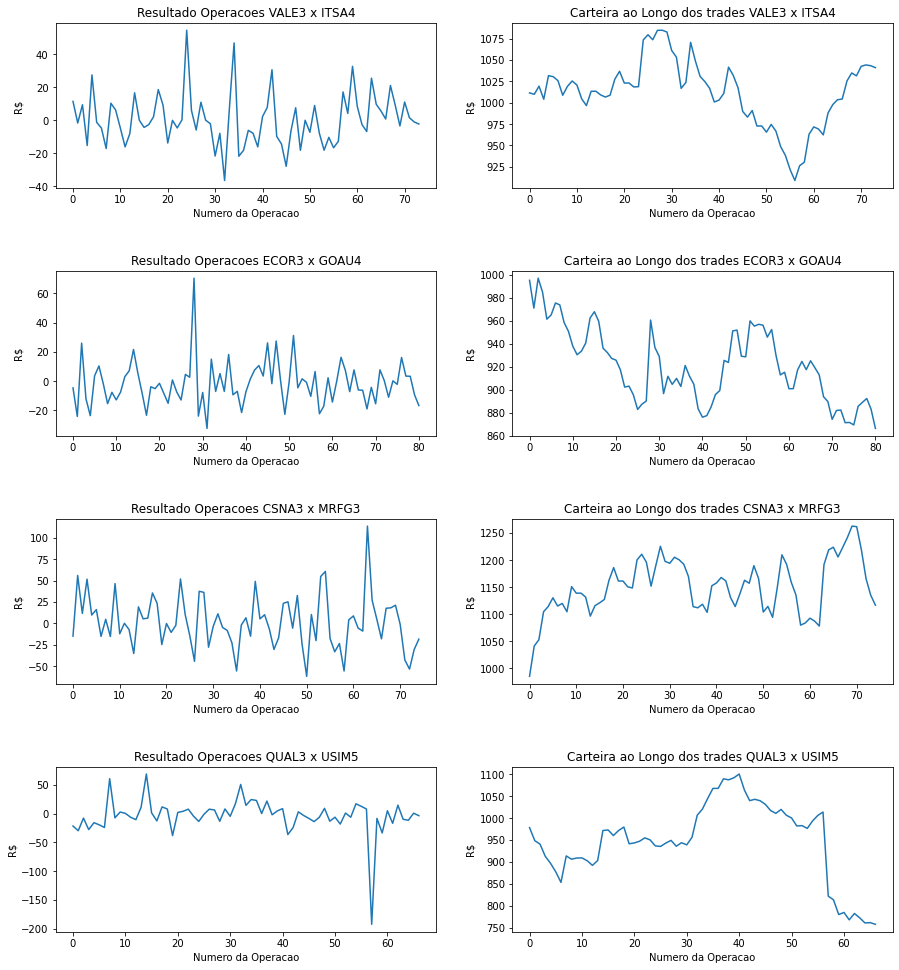

In [34]:
fig = plt.figure(figsize=(15, 30))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)

contador1 = 1
for i in lista_pares_usados:
    plt.subplot(8, 2, contador1)
    plt.plot(dic[i].lista_resultado_operacoes)
    plt.title('Resultado Operacoes '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    
    contador1 += 1
    plt.subplot(8, 2, contador1)
    plt.plot(dic[i].lista_evolucao_carteira)
    plt.title('Carteira ao Longo dos trades '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')

    contador1 += 1
    
plt.show()

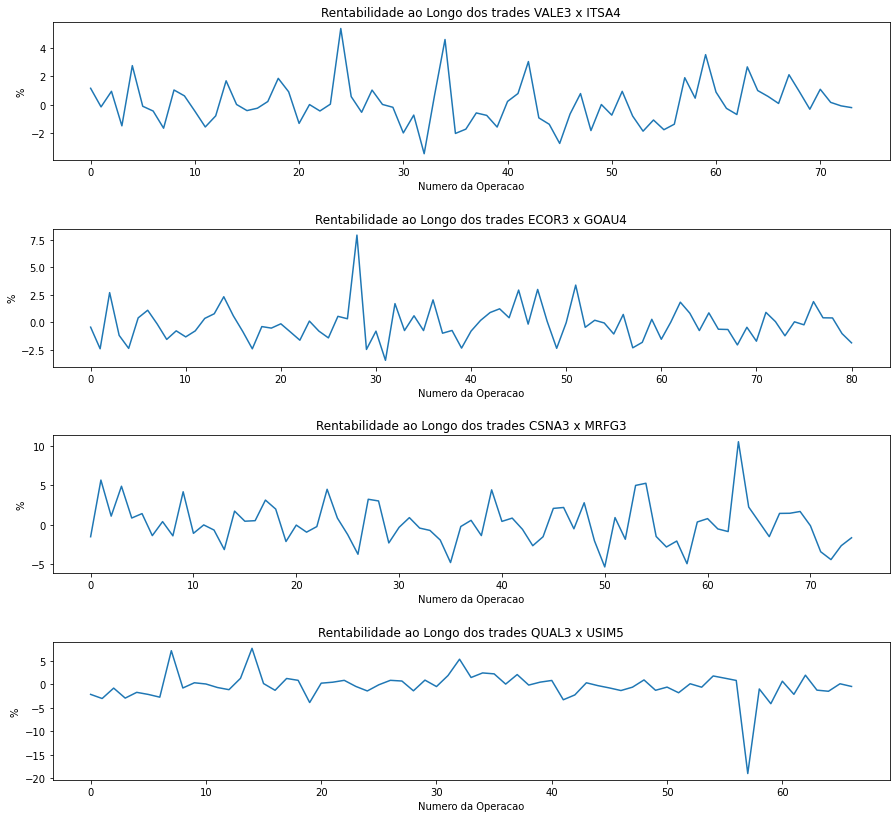

In [35]:
fig = plt.figure(figsize=(15, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)

contador1 = 1
for i in lista_pares_usados:
    
#     plt.subplot(8, 2, contador1)
#     plt.hist(dic[i].lista_dias_carregando, bins=8)
#     plt.title('Dias Posicionado '+ i)
#     plt.xlabel('Numero da Operacao')
#     plt.ylabel('R$')
#     contador1+=1

    plt.subplot(8, 1, contador1)
    plt.plot(dic[i].lista_rentabilidade_operacao)
    plt.title('Rentabilidade ao Longo dos trades '+ i)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('%')

    contador1 += 1

plt.show()

In [11]:
data

,time,close IBOV,close ABEV3,close AZUL4,close B3SA3,close BBAS3,close BBDC3,close BBDC4,close BBSE3,close BEEF3,...,close TAEE11,close TIMP3,close TOTS3,close UGPA3,close USIM5,close VALE3,close VIVT4,close VVAR3,close WEGE3,close YDUQ3
1,2016-01-22,38031,15.08,NaN,8.97,10.96,8.97,8.37,15.14,11.53,...,10.14,5.60,8.93,25.66,0.95,8.17,25.62,NaN,10.49,8.67
2,2016-01-26,37497,15.07,NaN,8.89,10.87,8.97,8.28,14.47,11.23,...,10.28,5.42,9.06,24.80,0.92,8.09,25.21,1.11,10.10,8.43
3,2016-01-27,38376,15.94,NaN,9.17,10.71,9.15,8.38,14.51,11.38,...,10.77,5.72,9.22,25.61,0.86,8.51,26.04,1.11,10.51,8.49
4,2016-01-28,38630,16.01,NaN,9.26,10.95,9.31,8.39,14.98,11.58,...,10.98,5.49,9.42,25.82,0.82,8.44,25.62,1.23,10.48,8.39
5,2016-01-29,40406,16.70,NaN,9.17,11.68,9.50,8.75,15.93,11.94,...,11.37,5.78,10.12,26.60,0.81,8.79,26.24,1.22,11.00,9.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,2019-12-20,115121,18.91,57.00,47.96,50.45,30.09,32.23,34.54,12.08,...,29.52,15.20,22.70,24.30,9.24,53.59,55.25,11.37,33.69,47.23
971,2019-12-23,115863,18.96,57.60,45.78,51.98,30.70,32.43,34.73,12.07,...,29.71,15.31,22.44,25.01,9.44,53.38,55.74,11.67,33.63,48.09
972,2019-12-26,117203,19.22,57.07,45.57,52.57,31.02,32.83,34.56,12.64,...,30.05,15.51,22.28,25.28,9.44,53.59,56.23,11.80,34.68,47.70
973,2019-12-27,116534,19.16,57.80,43.19,52.34,30.82,32.71,34.63,12.74,...,29.97,15.51,21.56,25.40,9.34,53.60,55.84,11.50,35.17,47.90


# Testando o modelo atual com os dados desse aqui

In [13]:
class senninha_long_and_short():
    def __init__(self,dados,t1,t2, financeiro_inicial, zs_l):
        #temos o par de tickers, os dados históricos de preço, e as variações históricas.
        self.zs_critico = zs_l
        self.t1, self.t2 = t1,t2
        self.dados = dados[['time',t1,t2]]
        self.dados_var = dados[[t1,t2]].pct_change()[1:]
        self.dados = self.dados[1:]
        self.s1, self.s2 = self.dados[self.t1], self.dados[self.t2]
        self.s1_var, self.s2_var = self.dados_var[self.t1], self.dados_var[self.t2]
        self.financeiro = financeiro_inicial
        #variaveis iniciais para tradar pares
        self.posicionado = 0
        self.compra_s1 = 0
        self.venda_s2 = 0
        #desempenho ao longo do tempo 
        self.l_resultado = []
        self.l_pct_operacoes = []
          
    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs, b
    
    def print_resultados(self, tipo, r): #rlong,rshort,result
        if tipo == 'entrada':
            print(f'entrou | V1 {self.venda_s1:.2f} X {self.v1} | C2 {self.compra_s2:.2f} X {self.v2}')
        elif tipo == 'saida':
            print(f'saiu   | C1 {self.compra_s1:.2f} X {self.v1} | V2 {self.venda_s2:.2f} X {self.v2}')
        elif tipo == 'resultado':
            print(f'result | s1 {r[0]:.2f} | s2 {r[1]:.2f} | l/p = {r[2]:.2f}\n')
    
    def condicoes_operar(self, zs_atual, cotacao1, cotacao2):
        if zs_atual >= self.zs_critico and self.posicionado == 0:
            razao = cotacao1/cotacao2
            volume = (self.financeiro/2)//cotacao1
            self.v1, self.v2 = int(volume), int(razao*volume)
            #definiu o numero de ações que comprará de cada
            self.venda_s1 = cotacao1*self.v1
            self.compra_s2  = cotacao2*self.v2 
            self.valor_total_trade = self.venda_s1+self.compra_s2
            self.print_resultados('entrada',r=None)
            self.posicionado = 1
        elif zs_atual <= 0.08 and self.posicionado == 1:
            self.posicionado = 0            
            #encerra posicao
            self.compra_s1 = cotacao1*self.v1
            self.venda_s2  = cotacao2*self.v2 
            self.print_resultados('saida',r=None)
            #resultado
            resultado_long  = self.venda_s1 - self.compra_s1
            resultado_short = self.venda_s2 - self.compra_s2
            resultado = resultado_long + resultado_short
            pct_operacao = (resultado/self.valor_total_trade)*100
            #resultados ao longo do tempo
            self.l_pct_operacoes.append(pct_operacao)
            self.l_resultado.append(resultado)
            self.print_resultados('resultado',[resultado_long,resultado_short,resultado])
            self.financeiro += resultado
            #reseta valor em carteira de cada ação
            self.compra_s1, self.venda_s1, self.compra_s2 ,self.venda_s2,  = 0, 0, 0, 0
            resultado, resultado_long, resultado_short = 0, 0, 0
            
    def loop_operador(self, window_size):
        c = 0
        for index in range(window_size, len(self.s1)):
            #stock data in the window range
            s1_var_w, s2_var_w = self.s1_var[c:index], self.s2_var[c:index]
            preco_s1, preco_s2 = self.s1[self.dados.index == index].values[0], self.s2[self.dados.index == index].values[0]
            #calculates the zscore of the spread
            resultado_funcao = self.calcula_zscore_spread(s1_var_w, s2_var_w)
            zs, beta = resultado_funcao[0], resultado_funcao[1]
            self.condicoes_operar(zs_atual=zs, cotacao1=preco_s1, cotacao2=preco_s2)   
            c+=1

In [14]:
dic_dados_pares = {}

In [15]:
zsl = 1.1

tickers = [['close VALE3','close ITSA4'],['close ECOR3','close GOAU4'],['close CSNA3','close MRFG3'],['close QUAL3','close USIM5']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']
for i in tickers:
    dic_dados_pares[str(i)] = senninha_long_and_short(data,i[0], i[1], 1000,zs_l = zsl)
    dic_dados_pares[str(i)].loop_operador(window_size=45)

entrou | V1 488.88 X 36 | C2 485.52 X 102
saiu   | C1 528.84 X 36 | V2 514.08 X 102
result | s1 -39.96 | s2 28.56 | l/p = -11.40

entrou | V1 481.95 X 35 | C2 477.85 X 95
saiu   | C1 502.25 X 35 | V2 499.70 X 95
result | s1 -20.30 | s2 21.85 | l/p = 1.55

entrou | V1 488.96 X 32 | C2 485.10 X 99
saiu   | C1 454.40 X 32 | V2 505.89 X 99
result | s1 34.56 | s2 20.79 | l/p = 55.35

entrou | V1 515.66 X 38 | C2 512.53 X 107
saiu   | C1 523.26 X 38 | V2 524.30 X 107
result | s1 -7.60 | s2 11.77 | l/p = 4.17

entrou | V1 516.24 X 36 | C2 515.74 X 107
saiu   | C1 540.00 X 36 | V2 535.00 X 107
result | s1 -23.76 | s2 19.26 | l/p = -4.50

entrou | V1 517.26 X 37 | C2 515.16 X 106
saiu   | C1 556.11 X 37 | V2 549.08 X 106
result | s1 -38.85 | s2 33.92 | l/p = -4.93

entrou | V1 507.15 X 35 | C2 502.74 X 98
saiu   | C1 512.40 X 35 | V2 517.44 X 98
result | s1 -5.25 | s2 14.70 | l/p = 9.45

entrou | V1 512.00 X 32 | C2 509.60 X 98
saiu   | C1 502.08 X 32 | V2 544.88 X 98
result | s1 9.92 | s2 35.2

entrou | V1 1275.12 X 21 | C2 1270.97 X 149
saiu   | C1 1226.19 X 21 | V2 1327.59 X 149
result | s1 48.93 | s2 56.62 | l/p = 105.55

entrou | V1 1297.12 X 22 | C2 1295.07 X 147
saiu   | C1 1287.44 X 22 | V2 1392.09 X 147
result | s1 9.68 | s2 97.02 | l/p = 106.70

entrou | V1 1346.88 X 24 | C2 1337.76 X 144
saiu   | C1 1336.56 X 24 | V2 1418.40 X 144
result | s1 10.32 | s2 80.64 | l/p = 90.96

entrou | V1 1408.25 X 25 | C2 1402.38 X 147
saiu   | C1 1409.00 X 25 | V2 1461.18 X 147
result | s1 -0.75 | s2 58.80 | l/p = 58.05

entrou | V1 1452.36 X 28 | C2 1449.60 X 151
saiu   | C1 1473.36 X 28 | V2 1505.47 X 151
result | s1 -21.00 | s2 55.87 | l/p = 34.87

entrou | V1 1448.20 X 26 | C2 1445.65 X 145
saiu   | C1 1387.88 X 26 | V2 1477.55 X 145
result | s1 60.32 | s2 31.90 | l/p = 92.22

entrou | V1 1508.64 X 28 | C2 1508.12 X 148
saiu   | C1 1514.52 X 28 | V2 1574.72 X 148
result | s1 -5.88 | s2 66.60 | l/p = 60.72

entrou | V1 1517.76 X 31 | C2 1509.69 X 147
saiu   | C1 1574.80 X 31 | V2 

entrou | V1 1694.54 X 193 | C2 1693.32 X 412
saiu   | C1 1684.89 X 193 | V2 1742.76 X 412
result | s1 9.65 | s2 49.44 | l/p = 59.09

entrou | V1 1718.64 X 186 | C2 1715.49 X 389
saiu   | C1 1740.96 X 186 | V2 1824.41 X 389
result | s1 -22.32 | s2 108.92 | l/p = 86.60

entrou | V1 1761.54 X 187 | C2 1757.80 X 374
saiu   | C1 1744.71 X 187 | V2 1810.16 X 374
result | s1 16.83 | s2 52.36 | l/p = 69.19

entrou | V1 1802.24 X 176 | C2 1797.78 X 361
saiu   | C1 1786.40 X 176 | V2 1877.20 X 361
result | s1 15.84 | s2 79.42 | l/p = 95.26

entrou | V1 1845.12 X 192 | C2 1842.40 X 376
saiu   | C1 1866.24 X 192 | V2 1913.84 X 376
result | s1 -21.12 | s2 71.44 | l/p = 50.32

entrou | V1 1875.30 X 190 | C2 1871.25 X 375
saiu   | C1 1818.30 X 190 | V2 1905.00 X 375
result | s1 57.00 | s2 33.75 | l/p = 90.75

entrou | V1 1918.35 X 203 | C2 1916.72 X 388
saiu   | C1 1912.26 X 203 | V2 2126.24 X 388
result | s1 6.09 | s2 209.52 | l/p = 215.61

entrou | V1 2023.84 X 208 | C2 2020.72 X 377
saiu   | C1 20

entrou | V1 8439.96 X 732 | C2 8434.88 X 1226
saiu   | C1 8264.28 X 732 | V2 8594.26 X 1226
result | s1 175.68 | s2 159.38 | l/p = 335.06

entrou | V1 8608.84 X 746 | C2 8603.63 X 1381
saiu   | C1 8713.28 X 746 | V2 8990.31 X 1381
result | s1 -104.44 | s2 386.68 | l/p = 282.24

entrou | V1 8748.00 X 720 | C2 8745.14 X 1513
saiu   | C1 8928.00 X 720 | V2 9410.86 X 1513
result | s1 -180.00 | s2 665.72 | l/p = 485.72

entrou | V1 8995.14 X 693 | C2 8994.93 X 1477
saiu   | C1 9009.00 X 693 | V2 9615.27 X 1477
result | s1 -13.86 | s2 620.34 | l/p = 606.48

entrou | V1 9288.00 X 688 | C2 9285.80 X 1601
saiu   | C1 9680.16 X 688 | V2 10054.28 X 1601
result | s1 -392.16 | s2 768.48 | l/p = 376.32

entrou | V1 9485.35 X 661 | C2 9480.00 X 1580
saiu   | C1 9326.71 X 661 | V2 9748.60 X 1580
result | s1 158.64 | s2 268.60 | l/p = 427.24

entrou | V1 9688.14 X 699 | C2 9685.40 X 1580
saiu   | C1 9730.08 X 699 | V2 10064.60 X 1580
result | s1 -41.94 | s2 379.20 | l/p = 337.26

entrou | V1 9858.75 X 

entrou | V1 1935.68 X 263 | C2 1935.45 X 255
saiu   | C1 1988.28 X 263 | V2 2062.95 X 255
result | s1 -52.60 | s2 127.50 | l/p = 74.90

entrou | V1 1971.06 X 247 | C2 1970.64 X 252
saiu   | C1 1867.32 X 247 | V2 2121.84 X 252
result | s1 103.74 | s2 151.20 | l/p = 254.94

entrou | V1 2098.11 X 309 | C2 2097.54 X 258
saiu   | C1 2156.82 X 309 | V2 2208.48 X 258
result | s1 -58.71 | s2 110.94 | l/p = 52.23

entrou | V1 2128.28 X 308 | C2 2121.93 X 271
saiu   | C1 2199.12 X 308 | V2 2211.36 X 271
result | s1 -70.84 | s2 89.43 | l/p = 18.59

entrou | V1 2133.12 X 264 | C2 2127.04 X 272
saiu   | C1 2106.72 X 264 | V2 2208.64 X 272
result | s1 26.40 | s2 81.60 | l/p = 108.00

entrou | V1 2189.00 X 275 | C2 2186.80 X 308
saiu   | C1 2290.75 X 275 | V2 2282.28 X 308
result | s1 -101.75 | s2 95.48 | l/p = -6.27

entrou | V1 2182.30 X 278 | C2 2177.92 X 328
saiu   | C1 2168.40 X 278 | V2 2233.68 X 328
result | s1 13.90 | s2 55.76 | l/p = 69.66

entrou | V1 2219.25 X 269 | C2 2214.45 X 399
saiu  

entrou | V1 1587.60 X 105 | C2 1584.60 X 380
saiu   | C1 1591.80 X 105 | V2 1698.60 X 380
result | s1 -4.20 | s2 114.00 | l/p = 109.80

entrou | V1 1649.46 X 111 | C2 1648.66 X 373
saiu   | C1 1665.00 X 111 | V2 1730.72 X 373
result | s1 -15.54 | s2 82.06 | l/p = 66.52

entrou | V1 1681.12 X 112 | C2 1677.65 X 377
saiu   | C1 1797.60 X 112 | V2 1911.39 X 377
result | s1 -116.48 | s2 233.74 | l/p = 117.26

entrou | V1 1739.07 X 113 | C2 1735.36 X 352
saiu   | C1 1731.16 X 113 | V2 1837.44 X 352
result | s1 7.91 | s2 102.08 | l/p = 109.99

entrou | V1 1787.52 X 114 | C2 1787.10 X 370
saiu   | C1 1760.16 X 114 | V2 1864.80 X 370
result | s1 27.36 | s2 77.70 | l/p = 105.06

entrou | V1 1842.50 X 125 | C2 1838.76 X 398
saiu   | C1 1787.50 X 125 | V2 1870.60 X 398
result | s1 55.00 | s2 31.84 | l/p = 86.84

entrou | V1 1887.60 X 132 | C2 1884.84 X 417
saiu   | C1 1925.88 X 132 | V2 1980.75 X 417
result | s1 -38.28 | s2 95.91 | l/p = 57.63

entrou | V1 1912.32 X 128 | C2 1909.98 X 486
saiu   

entrou | V1 13891.28 X 703 | C2 13891.02 X 1619
saiu   | C1 14067.03 X 703 | V2 14328.15 X 1619
result | s1 -175.75 | s2 437.13 | l/p = 261.38

entrou | V1 14022.45 X 705 | C2 14016.97 X 1613
saiu   | C1 14290.35 X 705 | V2 15468.67 X 1613
result | s1 -267.90 | s2 1451.70 | l/p = 1183.80

entrou | V1 14602.64 X 739 | C2 14601.86 X 1846
saiu   | C1 14580.47 X 739 | V2 15174.12 X 1846
result | s1 22.17 | s2 572.26 | l/p = 594.43

entrou | V1 14909.68 X 577 | C2 14904.21 X 1889
saiu   | C1 14442.31 X 577 | V2 15300.90 X 1889
result | s1 467.37 | s2 396.69 | l/p = 864.06

entrou | V1 15326.00 X 632 | C2 15323.00 X 2189
saiu   | C1 17203.04 X 632 | V2 16286.16 X 2189
result | s1 -1877.04 | s2 963.16 | l/p = -913.88

entrou | V1 14881.60 X 568 | C2 14879.95 X 2141
saiu   | C1 14569.20 X 568 | V2 16764.03 X 2141
result | s1 312.40 | s2 1884.08 | l/p = 2196.48

entrou | V1 15980.64 X 624 | C2 15975.20 X 2102
saiu   | C1 15606.24 X 624 | V2 17320.48 X 2102
result | s1 374.40 | s2 1345.28 | l/p 

['close VALE3', 'close ITSA4']: 4935.64
['close ECOR3', 'close GOAU4']: 22908.76
['close CSNA3', 'close MRFG3']: 14375.04
['close QUAL3', 'close USIM5']: 38220.57


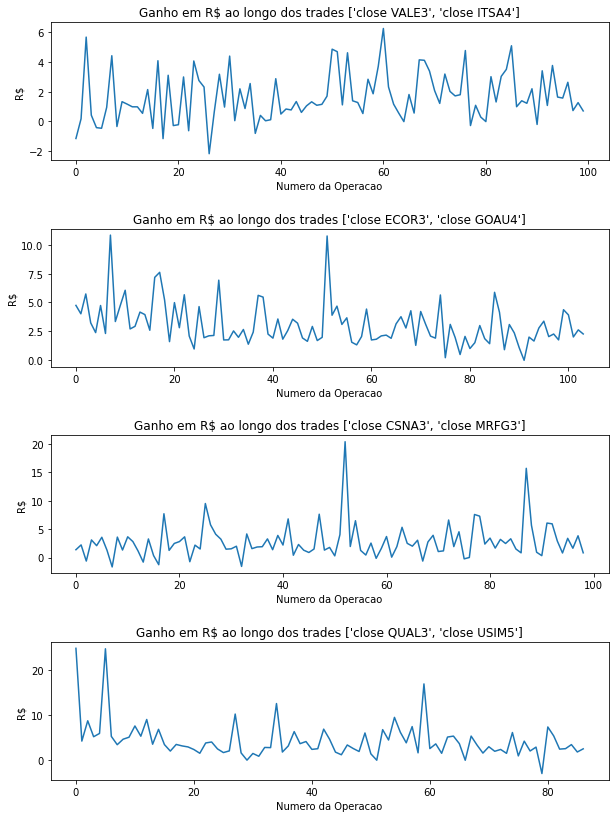

In [16]:
fig = plt.figure(figsize=(10, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
contador1 = 1

for k,v in dic_dados_pares.items():
    print(f'{k}: {v.financeiro:.2f}')
    plt.subplot(8, 1, contador1)
    plt.title('Ganho em R$ ao longo dos trades '+ k)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    plt.plot(v.l_pct_operacoes)
    contador1 += 1

['close BBDC3', 'close BTOW3']: 37719.21
['close ECOR3', 'close GOLL4']: 62977.75
['close CSNA3', 'close MRFG3']: 14375.04
['close QUAL3', 'close USIM5']: 38220.57


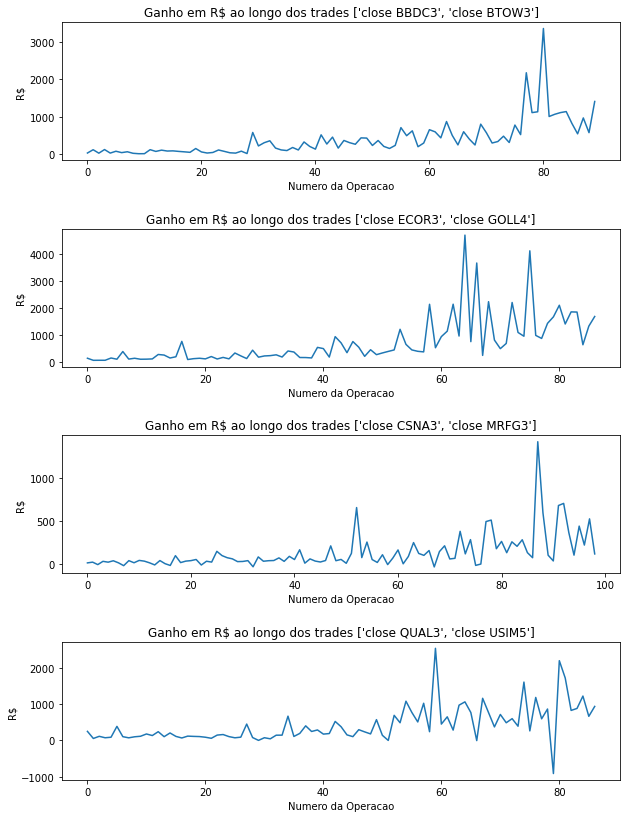

In [35]:
fig = plt.figure(figsize=(10, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
contador1 = 1

for k,v in dic_dados_pares.items():
    print(f'{k}: {v.financeiro:.2f}')
    plt.subplot(8, 1, contador1)
    plt.title('Ganho em R$ ao longo dos trades '+ k)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    plt.plot(v.l_resultado)
    contador1 += 1
